## 1_Cleaning

The original dataset comprised 200k news articles, with an average token count of about 1,200 per article, spanning from January 2020 to February 2024. Following a process, it was reduced to 157k by:
1. Exclude Outlier: The distribution of Token Count is right-tailed, meaning that articles with a very high Token Count take a long time to analyze and should be excluded. Similarly, articles with a very low Token Count should also be excluded due to their lack of information. Therefore, the top and bottom 1% of articles by Token Count are excluded.
2. Removing News Weakly Related to AI: Articles that did not mention 'Artificial Intelligence' or 'AI' within the first 30% were excluded, by adopting the point where the curve becomes more gradual (refer to the right figure). Notably, using 'Artificial Intelligence' alone would exclude too many articles, whereas including related terms like 'Machine Learning' did not significantly alter the outcome.
3. Removing Non-English News: Articles not in English were eliminated.
During data cleaning, URLs and special characters were removed, and whitespace was normalized using regular expressions.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from spacy.language import Language
import spacy
from spacy_langdetect import LanguageDetector

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%%time

df = pd.read_parquet('news_final_project.parquet', engine='pyarrow')
df.shape

CPU times: user 5.57 s, sys: 6.77 s, total: 12.3 s
Wall time: 50.1 s


(200435, 5)

In [3]:
df.head()

,url,date,language,title,text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor..."
2,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,2020-03-13,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articolo\nHome page\n\n\nAttualitÃ \n\n\nAmbiente\nCronaca\nCronaca Locale\nCultura\nEconomia\nEuropa\nMedia\nIstruzione\nMondo\nPolitica\nSalute\nReligione\nSocietÃ \nScienza e Tecnologia\nTribuna Libera\n\n\tDi' la tua\n\n\nTempo Libero\n\n\nGossip\nRedazionali\nConcorsi\nCinema\nFame&Tulipani\nIncredibile ma vero!\nLa vignetta del giorno...
3,http://www.desototimes.com/news/child-actor-claude-jarman-jr-looks-back-on-his-movie-career-during-the-golden-days/article_0b310fae-e767-11ec-982e-a380305dda2f.html,2022-06-09,en,Child actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com,\nChild actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com\nSkip to main content\n\nYou have permission to edit this article.\n\n Edit\nClose\n\nHome\nNews\n\n\nNews\n\nLocal News\n\nFaith & Worship\n\n\nBusiness\nSports\n\n\nSports\n\nLocal Sports\n\nOutdoor Report\n\nOpinion\n\n\nOpinion\n\nLetters to the Editor\n\nSubmit a Letters to the Editor\n\n\nObituaries\nLifestyle\n\n\nLifestyle\n\nFeatures\n\nCommunity Calendar\n\n...
4,http://www.millenniumpost.in/big-stories/ai-express-aircraft-skids-off-runaway-in-kozhikode-rescue-ops-on-414926,2020-08-07,en,Two dead as AI Express flight skids off Kozhikode airport,Two dead as AI Express flight skids off Kozhikode airportTopLoginSubscribeToggle navigationFeaturesDelhiKolkataNationOpinionEditorialBusinessSportsSunday PostBeyond BygoneEpic PowerIn RetrospectGlobal EyeInlandRoutesBeaconInsightGame OnSafariTrendingCandid TalkGastronomyFact FilesMapping the states of IndiaX/sunday-post/beyond-bygone/sunday-post/epic-power/fact-files/ians-feeds/sundaypost/in-retrospect/mapping-the-states-of-india/puja-special/Reminiscence/sponsored/sundaypost/global-eye/feat...


In [4]:
df['title'][0]

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis'

In [5]:
df['text'][0]

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis          \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026: Apollo Games, Sony, Aristocrat Leisure, IGT\nInfectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics\nVeterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA\nVeterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited\nVeterinary Holters Market Compr

## Clean-up the noise, by eliminating newlines, tabs, remnants of web crawls, and other irrelevant text

In [6]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove characters not in the specified set (alphabets, digits, spaces, single quotes, hyphens, and periods)
    text = re.sub(r'[^A-Za-z0-9\s\'\-\.]', '', text)
    
    # Remove extra spaces, tabs, and newlines
    text = re.sub(r'\s+', ' ', text).strip()  # Convert multiple spaces, tabs, or newlines to a single space and trim
    
    return text

In [7]:
# Clean title
df['title'] = df['title'].apply(clean_text)
# Clean text
df['text'] = df['text'].apply(clean_text)

In [8]:
clean_text(df['title'][0])

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis'

In [9]:
clean_text(df['text'][0])

'LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026 Apollo Games Sony Aristocrat Leisure IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher BD Roche Diagnostics Veterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca Midmark Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik Gowllands Limited Veterinary Holters Market Comprehensive Study by Companies Dextronix Nasiff Assoc

## Discard irrelevant articles

In [10]:
# Count the number of tokens in each row of the 'text' column and add it to a new column 'token_count'
df['token_count'] = df['text'].apply(lambda x: len(x.split()))

In [11]:
# token count stats
df['token_count'].describe()

count    200435.000000
mean       1203.657435
std         938.340099
min           4.000000
25%         718.000000
50%         999.000000
75%        1462.000000
max       39099.000000
Name: token_count, dtype: float64

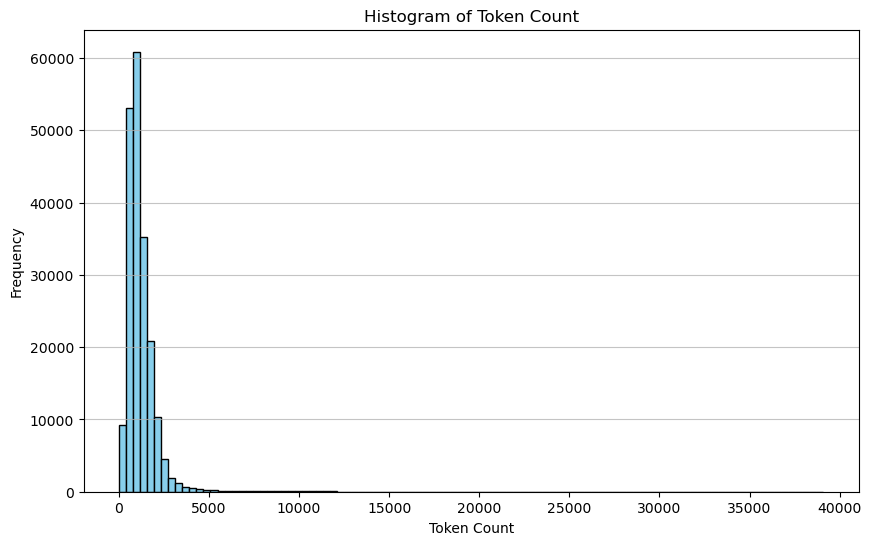

In [12]:
# Plot the histogram of the 'token_count' column
plt.figure(figsize=(10, 6))
plt.hist(df['token_count'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Token Count') 
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

- The distribution of Token Count is right-tailed, meaning that articles with a very high Token Count take a long time to analyze and should be excluded. 
- Similarly, articles with a very low Token Count should also be excluded due to their lack of information. 
- Therefore, the top and bottom 1% of articles by Token Count are excluded.

In [13]:
# Calculate the 1.0% and 99.0% percentiles of the 'token_count' column
lower_percentile = df['token_count'].quantile(0.01)
upper_percentile = df['token_count'].quantile(0.99)

print('lower count: ', round(lower_percentile, 1))
print('upper count: ', round(upper_percentile, 1))

lower count:  130.0
upper count:  4524.0


In [14]:
# Filter the DataFrame to exclude rows outside the 1.0% to 99.0% percentile range
df = df[(df['token_count'] >= lower_percentile) & (df['token_count'] <= upper_percentile)]

In [15]:
def flag_rows_by_word(df, column_name, rel_words, percentage):
    """
    Flags rows based on the presence of any of the specified words within a certain percentage of the text column.
    
    Parameters:
    - df: DataFrame containing the text data.
    - column_name: Name of the column to search for words.
    - rel_words: List of relevant words or phrases to search for.
    - percentage: Percentage of the text (from the beginning) within which to search for the words.
    
    Returns:
    - DataFrame with an additional 'rel_flag' column, where 1 indicates the presence of any of the specified words within the specified percentage of the text, and 0 indicates their absence.
    """
    def check_presence_in_part(text, words, percentage):
        # Calculate the length of text to consider based on the percentage
        part_length = int(len(text) * (percentage / 100))
        text_part = text[:part_length]
        # Compile a regex pattern for each word with word boundaries and case-insensitive search
        patterns = [re.compile(r'\b' + re.escape(word) + r'\b', re.IGNORECASE) for word in words]
        # Check if any of the compiled regex patterns match within the specified part of the text
        return any(pattern.search(text_part) for pattern in patterns)
    
    # Apply the modified check to each row and set the 'rel_flag' column
    df['rel_flag'] = df[column_name].apply(lambda text: check_presence_in_part(text, rel_words, percentage)).astype(int)
    
    return df

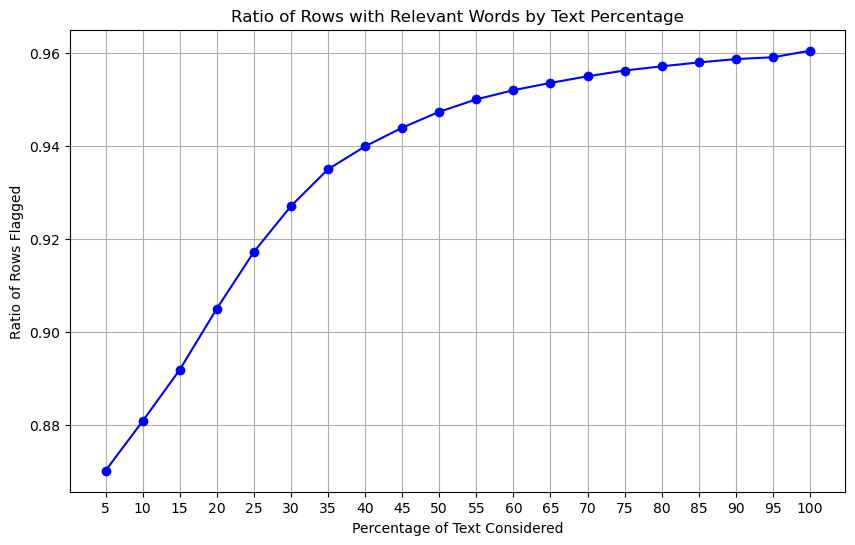

In [16]:
# Set relevant words
rel_words = ['Artificial Intelligence', 'AI', 'Data Science', 'Machine Learning', 'ML']

# Initialize list to store the ratios and the percentages
ratios = []
percentages = range(5, 101, 5)

# Iterate over the specified percentages
for percentage in percentages:
    df_temp = flag_rows_by_word(df.copy(), 'text', rel_words, percentage)
    ratio = df_temp['rel_flag'].sum() / len(df_temp['rel_flag'])
    ratios.append(ratio)

# Plotting the ratios
plt.figure(figsize=(10, 6))
plt.plot(percentages, ratios, marker='o', linestyle='-', color='blue')
plt.title('Ratio of Rows with Relevant Words by Text Percentage')
plt.xlabel('Percentage of Text Considered')
plt.ylabel('Ratio of Rows Flagged')
plt.xticks(percentages)
plt.grid(True)
plt.show()

- About 87% of news articles mention relevant words in the first 5% of the text. 
- Approximately 4% of news articles do not mention relevant words throughout the entire content (100%), and these should be excluded. 
- It is assumed that articles strongly related to the topic mention relevant words towards the beginning. 
- The angle of the graph becomes gentler around the 30-40% mark, and this point could be used as a criterion for excluding irrelevant news articles.

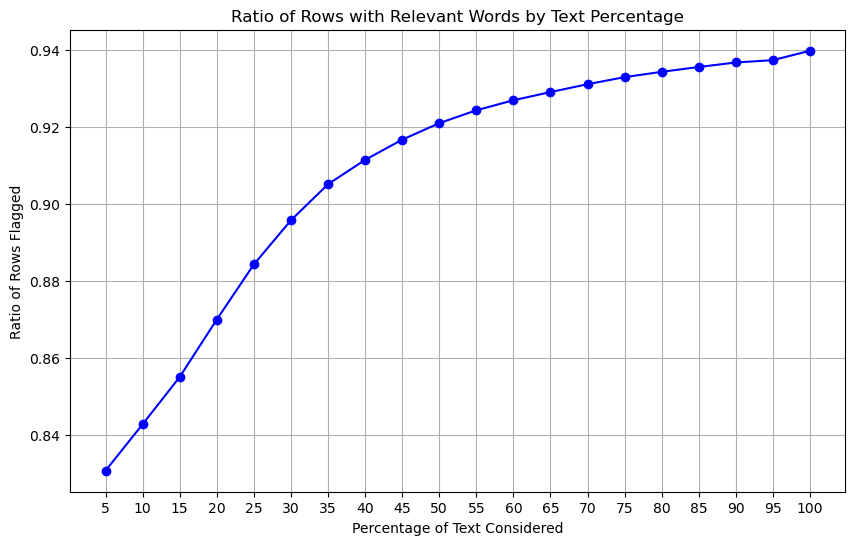

In [17]:
# Set relevant words - only 'Artificial Intelligence', 'AI'
rel_words = ['Artificial Intelligence', 'AI']

# Initialize list to store the ratios and the percentages
ratios = []
percentages = range(5, 101, 5)

# Iterate over the specified percentages
for percentage in percentages:
    df_temp = flag_rows_by_word(df.copy(), 'text', rel_words, percentage)
    ratio = df_temp['rel_flag'].sum() / len(df_temp['rel_flag'])
    ratios.append(ratio)

# Plotting the ratios
plt.figure(figsize=(10, 6))
plt.plot(percentages, ratios, marker='o', linestyle='-', color='blue')
plt.title('Ratio of Rows with Relevant Words by Text Percentage')
plt.xlabel('Percentage of Text Considered')
plt.ylabel('Ratio of Rows Flagged')
plt.xticks(percentages)
plt.grid(True)
plt.show()

- Even when narrowing down to keywords related to 'Artificial Intelligence' and 'AI', the numbers did not change much. 
- In other words, most articles mentioning 'Data Science', 'Machine Learning', 'ML' also mention 'Artificial Intelligence', 'AI'. 
- Given the purpose of this analysis, it seems appropriate to use only 'Artificial Intelligence' and 'AI'.

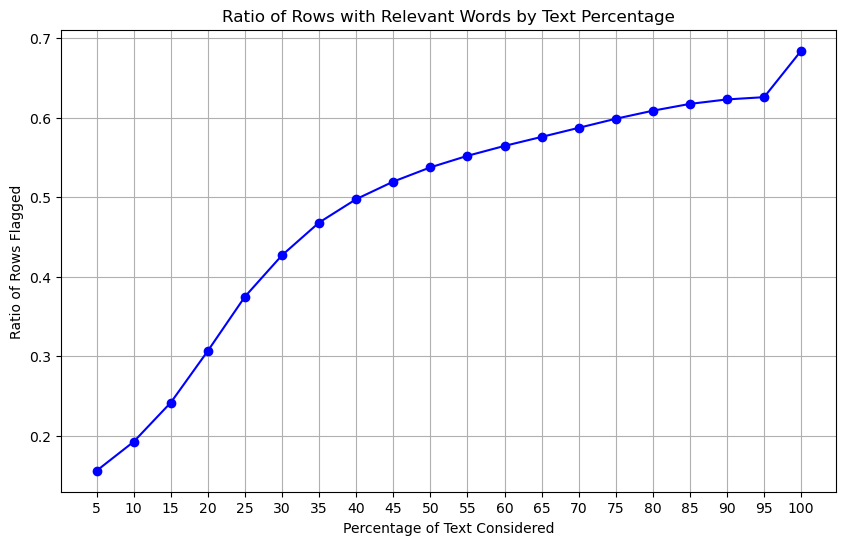

In [18]:
# Set relevant words - only 'Artificial Intelligence'
rel_words = ['Artificial Intelligence']

# Initialize list to store the ratios and the percentages
ratios = []
percentages = range(5, 101, 5)

# Iterate over the specified percentages
for percentage in percentages:
    df_temp = flag_rows_by_word(df.copy(), 'text', rel_words, percentage)
    ratio = df_temp['rel_flag'].sum() / len(df_temp['rel_flag'])
    ratios.append(ratio)

# Plotting the ratios
plt.figure(figsize=(10, 6))
plt.plot(percentages, ratios, marker='o', linestyle='-', color='blue')
plt.title('Ratio of Rows with Relevant Words by Text Percentage')
plt.xlabel('Percentage of Text Considered')
plt.ylabel('Ratio of Rows Flagged')
plt.xticks(percentages)
plt.grid(True)
plt.show()

- Narrowing down to keywords related only to 'Artificial Intelligence' significantly reduces the overall numbers. 
- This means that many articles exist that use the word 'AI' instead of 'Artificial Intelligence'. 
- Therefore, it is better to use both 'Artificial Intelligence' and 'AI'.

Based on the above analysis, use articles that include 'Artificial Intelligence' or 'AI' in the first 30% of the text (just under 90% of all articles).

In [19]:
df.shape

(196429, 6)

In [20]:
rel_words = ['Artificial Intelligence', 'AI']
percentage = 30

df = flag_rows_by_word(df, 'text', rel_words, percentage)
df_cleaned = df[df['rel_flag'] == 1]

In [21]:
df_cleaned.shape

(175945, 7)

Next, check whether the title also contains related keywords. 

In [22]:
df_cleaned = flag_rows_by_word(df_cleaned, 'title', rel_words, percentage=100)

# The proportion of articles with related keywords
df_cleaned['rel_flag'].sum()/len(df_cleaned['rel_flag'])

0.9182585467049362

- The proportion of articles with related keywords in the title is 92%. Since the proportion of articles without related keywords is small, it is considered that excluding them will not pose a problem.
- Therefore, to focus on articles more strongly related, those without related keywords in the title are excluded.

In [23]:
# Exclude news without related keywords in the title
df_cleaned = df_cleaned[df_cleaned['rel_flag'] == 1]

In [24]:
df_cleaned.shape

(161563, 7)

## Discard non-English results

In [27]:
# Register LanguageDetector in spaCy's factory
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector()

In [32]:
# Load the model
nlp = spacy.load("en_core_web_sm")

# Add the registered LanguageDetector to the pipeline
nlp.add_pipe("language_detector")

# Process the text and detect the language
doc = nlp("This is an English text.")
print(doc._.language)

{'language': 'en', 'score': 0.9999972257377296}


In [33]:
# Function to determine if the text is in English
def is_english(text):
    doc = nlp(text)
    return doc._.language['language'] == 'en'

# Wrapper function to apply the function to a specific column of a DataFrame
def apply_is_english(df, column):
    return df[df[column].apply(is_english)]

In [34]:
# Apply English filtering (both title and text)
df_cleaned_eng = df_cleaned[df_cleaned['title'].apply(is_english) & df_cleaned['text'].apply(is_english)]

In [35]:
df_cleaned_eng.shape

(157054, 7)

In [36]:
df_cleaned_eng.head()

,url,date,language,title,text,token_count,rel_flag
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Mach...,935,1
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday February 27 2020 Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March 2021 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real...,1557,1
4,http://www.millenniumpost.in/big-stories/ai-express-aircraft-skids-off-runaway-in-kozhikode-rescue-ops-on-414926,2020-08-07,en,Two dead as AI Express flight skids off Kozhikode airport,Two dead as AI Express flight skids off Kozhikode airportTopLoginSubscribeToggle navigationFeaturesDelhiKolkataNationOpinionEditorialBusinessSportsSunday PostBeyond BygoneEpic PowerIn RetrospectGlobal EyeInlandRoutesBeaconInsightGame OnSafariTrendingCandid TalkGastronomyFact FilesMapping the states of IndiaXsunday-postbeyond-bygonesunday-postepic-powerfact-filesians-feedssundaypostin-retrospectmapping-the-states-of-indiapuja-specialReminiscencesponsoredsundaypostglobal-eyefeaturesnationworld...,263,1
5,http://www.nativestew.com/2023/11/ai-took-my-job.html,2023-11-20,en,Native Stew - Bahamas AI Art Photos Videos AI Took My Job,Native Stew - Bahamas AI Art Photos Videos AI Took My Job Pages Home People Places Things Monday November 20 2023 AI Took My Job AI Took My Job - AI artA. Derek Catalano at November 20 2023 Email ThisBlogThisShare to TwitterShare to FacebookShare to Pinterest Labels Art People Newer Post Older Post Home Go Fund Me My daughter-in-law Gayle. Please help. Translate About Me A. Derek Catalano Photos videos and art featuring the people places and things of The Bahamas. I've traveled to many islan...,328,1
8,http://www.sbwire.com/press-releases/healthcare-artificial-intelligence-market-next-big-thing-major-giants-general-electric-medtronic-aicure-apixio-1363690.htm,2022-10-06,en,Healthcare Artificial Intelligence Market Analysis and Forecast for Next 5 Years,Healthcare Artificial Intelligence Market Analysis and Forecast for Next 5 Years SBWire Sign Up Login Our Service Plans Pricing Newsroom Help About AMA Research amp Media LLP Email Alerts RSS Healthcare Artificial Intelligence Market Next Big Thing Major Giants- General Electric Medtronic AiCure APIXIO Healthcare Artificial Intelligence Market 2022-2028 New Jersey USA -- SBWIRE -- 10052022 -- Advance Market Analytics published a new research publication on Healthcare Artificial Intelligence ...,780,1


In [37]:
# Add doc_id(unique id for news)
df_cleaned_eng.insert(0, 'doc_id', range(1, 1 + len(df)))

In [38]:
# Drop 'rel_flag'
df_cleaned_eng = df_cleaned_eng.drop('rel_flag', axis=1)

In [39]:
df_cleaned_eng.head(2)

,doc_id,url,date,language,title,text,token_count
0,1,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis,LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Mach...,935
1,2,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday February 27 2020 Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March 2021 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real...,1557


In [40]:
# Specify the file path where the Parquet file will be saved
file_path = 'cleaned_data.parquet'

# Save the DataFrame as a Parquet file
df_cleaned_eng.to_parquet(file_path)